## Linear Regression with HOG Features on Cars

This notebook contains our linear regression model for price prediction on the Cars dataset.

We generate histogram of oriented gradients (HOG) features using the VGG-16 network, and reduce their dimensionality using PCA.

We then train linear regression on the training set, and report evaluation metrics on the test set.

### Imports

In [26]:
from sklearn.decomposition import PCA

import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import tensorflow as tf
import csv

from matplotlib.image import imread
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import data as skim_data 
from skimage import io, color, exposure
from skimage.transform import resize, rescale, rotate, setup, warp, AffineTransform

### Extract and Save Features

We run the dataset through VGG-16, extracting the activations of the last feature layer as our high-dimensional feature vectors. We then reduce the dimensionality using PCA.

In [27]:
from skimage.feature import hog
data_path = "../datasets/"

im_prices = np.zeros(1478)
images = []
with open(data_path + "cars_filtered.csv", "r") as file:
    counter = 0
    for line in file:
        line_arr = line.split(',')
        img_path = data_path + 'cars_im/' + line_arr[0] + '.jpg'
        img_file = imread(img_path)
        curr_im = color.rgb2gray(img_file)
        im_prices[counter] = int(line_arr[3])
        counter+=1
        images.append(curr_im)

In [29]:
hog_array = np.zeros((len(images), 224*224))
print("hogarray")
print(hog_array)

for i, image in enumerate(images):
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(32, 32),
                        cells_per_block=(1, 1), visualise=True, block_norm='L2-Hys')
    flattened_len = int(hog_image.shape[0]) * int(hog_image.shape[1])
    pixels = np.reshape(hog_image, (-1, flattened_len))
    hog_array[i, :] = pixels
    
    if i % 1000 == 0:
        print(i)

pca = PCA(n_components=2)
pca.fit(hog_array)
hog_images_compressed = pca.transform(hog_array)
print(hog_images_compressed)

pca = PCA(n_components=200)
pca.fit(hog_array)
hog_images_compressed = pca.transform(hog_array)

np.save("car_linreg_hog_pca_features", hog_images_compressed)
np.save("car_linreg_hog_pca_components", pca.components_)

hogarray
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0
1000
[[-0.13996553 -0.09962081]
 [-0.11600198 -0.07531632]
 [-0.11600198 -0.07531632]
 ..., 
 [-0.06575981 -0.00107988]
 [ 0.31512105  0.00462354]
 [ 0.31512105  0.00462354]]


In [30]:
car_indices = np.random.permutation(1478)
car_train_indices = car_indices[:1330]
car_test_indices = car_indices[1331:]

np.save("cars_train_indices", car_train_indices)
np.save("car_test_indices", car_test_indices)

### Linear Regression using HOG Features

We train linear regression on the PCA-processed HOG features on our training split, then evaluate on the test split.

We report three different metrics: MSE (mean squared error), MAE (mean absolute error), and R^2 (coefficient of determination)

In [31]:
# Load training and eval data
cnn_feats_compressed = np.load("car_linreg_hog_pca_features.npy")

train_inds = np.load('cars_train_indices.npy')
test_inds = np.load('cars_test_indices.npy')

train_data = cnn_feats_compressed[train_inds]
train_labels = im_prices[train_inds]

test_data = cnn_feats_compressed[test_inds]
test_labels = im_prices[test_inds]


regr = linear_model.LinearRegression()

regr.fit(train_data, train_labels)

predicted = regr.predict(test_data)

# Metrics
MSE = mean_squared_error(test_labels, predicted)
MAE = mean_absolute_error(test_labels, predicted)
R2 = r2_score(test_labels, predicted)

print("Mean squared error: %.2f" % MSE)
print("Mean absolute error: %.2f" % MAE)
print('Coefficient of determination: %.2f' % R2)

Mean squared error: 1755482924.90
Mean absolute error: 27588.70
Coefficient of determination: 0.70


In [32]:
error = []
for a,b in zip(test_labels, predicted):
    error.append((np.absolute(a-b),a,b))
error.sort(key=lambda x: x[0])

error_x = range(len(error))
error_val = []
error_y_label = []
error_y_pred = []
for e in error:
    error_val.append(e[0])
    error_y_label.append(e[1])
    error_y_pred.append(e[2])

Text(0,0.5,'Absolute Error')

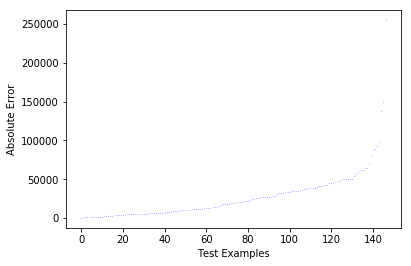

In [33]:
plt.scatter(error_x, error_val,  color='blue', s=0.01)
plt.xlabel('Test Examples')
plt.ylabel('Absolute Error')